"""
SEP 769: Cyber Physical System
References: 
1. Dataset = https://www.kaggle.com/datasets/garystafford/environmental-sensor-data-132k
2. Dr. Anwar Mirza's Lecture Notes
3. https://machinelearningmastery.com/gentle-introduction-long-short-term-memory-networks-experts/
4. Youtube Channels: https://www.youtube.com/watch?v=UbvkhuqVqUI&t=926s&ab_channel=KrishNaik
"""

**Import Libraries**

In [1]:
import numpy as np
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.models import Sequential
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

**Global Valriable**

In [2]:
y_variable = 'lpg'
datapoints_train = 8

**Load Dataset**

In [3]:
def load_clean_dataset():
  dataset = pd.read_csv('./iot_telemetry_data.csv')
  print("Original dimension of the", y_variable, "column is", dataset[y_variable].shape)
  return dataset

dataset = load_clean_dataset()

Original dimension of the lpg column is (405184,)


**Convert Timestamp to Date format**

In [4]:
def timestamp_to_date(dataset):
  dataset['ts']= pd.to_datetime(dataset['ts'], unit='s')          #Convert timestamp to date
  print('Dataset with replaced timstamp column looks like:')
  print(dataset[['ts',y_variable]])
  return dataset

timestamp_to_date(dataset)

Dataset with replaced timstamp column looks like:
                                  ts       lpg
0      2020-07-12 00:01:34.385974528  0.007651
1      2020-07-12 00:01:34.735567616  0.005114
2      2020-07-12 00:01:38.073572864  0.007673
3      2020-07-12 00:01:39.589145856  0.007023
4      2020-07-12 00:01:41.761234944  0.007664
...                              ...       ...
405179 2020-07-20 00:03:33.162014976  0.006247
405180 2020-07-20 00:03:33.576560640  0.008660
405181 2020-07-20 00:03:36.167959296  0.007181
405182 2020-07-20 00:03:36.979521536  0.006247
405183 2020-07-20 00:03:37.264312576  0.008695

[405184 rows x 2 columns]


,ts,device,co,humidity,light,lpg,motion,smoke,temp
0,2020-07-12 00:01:34.385974528,b8:27:eb:bf:9d:51,0.004956,51.000000,False,0.007651,False,0.020411,22.700000
1,2020-07-12 00:01:34.735567616,00:0f:00:70:91:0a,0.002840,76.000000,False,0.005114,False,0.013275,19.700001
2,2020-07-12 00:01:38.073572864,b8:27:eb:bf:9d:51,0.004976,50.900000,False,0.007673,False,0.020475,22.600000
3,2020-07-12 00:01:39.589145856,1c:bf:ce:15:ec:4d,0.004403,76.800003,True,0.007023,False,0.018628,27.000000
4,2020-07-12 00:01:41.761234944,b8:27:eb:bf:9d:51,0.004967,50.900000,False,0.007664,False,0.020448,22.600000
...,...,...,...,...,...,...,...,...,...
405179,2020-07-20 00:03:33.162014976,00:0f:00:70:91:0a,0.003745,75.300003,False,0.006247,False,0.016437,19.200001
405180,2020-07-20 00:03:33.576560640,b8:27:eb:bf:9d:51,0.005882,48.500000,False,0.008660,False,0.023301,22.200000
405181,2020-07-20 00:03:36.167959296,1c:bf:ce:15:ec:4d,0.004540,75.699997,True,0.007181,False,0.019076,26.600000
405182,2020-07-20 00:03:36.979521536,00:0f:00:70:91:0a,0.003745,75.300003,False,0.006247,False,0.016437,19.200001


**Plot Dataset**

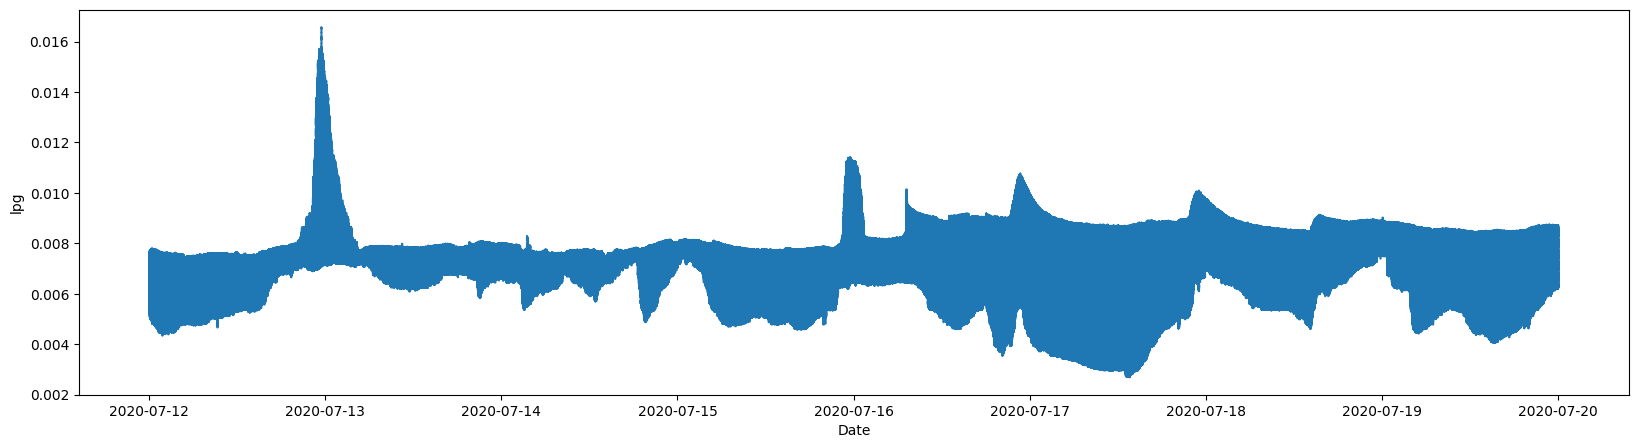

In [5]:
def plot(dataset):
  plt.figure(figsize=(20,5))
  plt.xlabel('Date')
  plt.ylabel(y_variable)
  plt.plot(dataset['ts'], dataset[y_variable], linestyle='dashed')
  plt.show()

plot(dataset)

**Normalise Dataset**

In [6]:
def normalise(dataset):
  y_variable_mean = np.mean(dataset[y_variable])
  y_variable_sd = np.std(dataset[y_variable])
  dataset[y_variable] = (dataset[y_variable] - y_variable_mean) / y_variable_sd                 #Standardize values with 0 mean and 1 variance
  return dataset

**Split into train and test set**

In [7]:
def split_train_test(dataset):
  train, test = train_test_split(dataset[y_variable], test_size=0.1, shuffle=False)    #in-biult sklearn method to split data into train and test
  test = test.reset_index()                                                            #reset index of test data
  test = test[y_variable]                                                              #remove additional index coloumn
  print('The shape of Training Data is: ', train.shape)
  print('The shape of Testing Data is: ', test.shape)
  print(test)
  return train, test

**Data Preparation**

In [8]:
def prepare_data(data, type):																										#Prepare data as Time-series inputs v/s Next LPG value
	X, y = [],[]
	for i in range(len(data)):
		last_day = i + datapoints_train																														#Taking data of 7 previous days
		if last_day > len(data)-1:																									#For last value
			break
		prev_data, next_price = data[i:last_day], data[last_day]
		X.append(prev_data)																													#Create Input set
		y.append(next_price)																												#Create corresponding Output set
	if type == 'train':
		print('X_train shape is:', np.array(X).shape)
		print('y_train shape is:', np.array(y).shape)
	else:
		print("X_test shape is:", np.array(X).shape)
		print("y_test shape is:", np.array(y).shape)

	return np.array(X), np.array(y)																								#Numpy conversion for sequential model

In [9]:
def reshape(X):
  X = X.reshape((X.shape[0], X.shape[1], 1))                                    #reshape input to [Batch_size, Number_of_Timesteps, One_Timestep_at_a_time]
  return X

**Plot Predictions**

In [10]:
def plot_ypred(dataset, train_length, y_test, y_pred):
  plt.figure(figsize=(20, 5))
  plt.xlabel('Date')
  plt.ylabel(y_variable)
  plt.plot(dataset['ts'][train_length+datapoints_train:], y_test, label='y_test', linestyle='dashed')
  plt.plot(dataset['ts'][train_length+datapoints_train:], y_pred, label='y_pred', linestyle='dashed' )
  plt.legend()
  plt.show()

**Loss Metrics**

In [11]:
def loss_metrics(actual, pred):
  rmse = np.sqrt(mean_squared_error(actual, pred))
  mae = mean_absolute_error(actual, pred)
  r2 = r2_score(actual, pred)
  print("RMSE between y_pred and y is {}".format(round(rmse, 3)))
  print("Mean Absolute Error between y_pred and y is {}".format(round(mae, 3)))
  print("R2_Score between y_pred and y is {}".format(round(r2, 3)))

**Main Function**

Original dimension of the lpg column is (405184,)
Dataset with replaced timstamp column looks like:
                                  ts       lpg
0      2020-07-12 00:01:34.385974528  0.007651
1      2020-07-12 00:01:34.735567616  0.005114
2      2020-07-12 00:01:38.073572864  0.007673
3      2020-07-12 00:01:39.589145856  0.007023
4      2020-07-12 00:01:41.761234944  0.007664
...                              ...       ...
405179 2020-07-20 00:03:33.162014976  0.006247
405180 2020-07-20 00:03:33.576560640  0.008660
405181 2020-07-20 00:03:36.167959296  0.007181
405182 2020-07-20 00:03:36.979521536  0.006247
405183 2020-07-20 00:03:37.264312576  0.008695

[405184 rows x 2 columns]


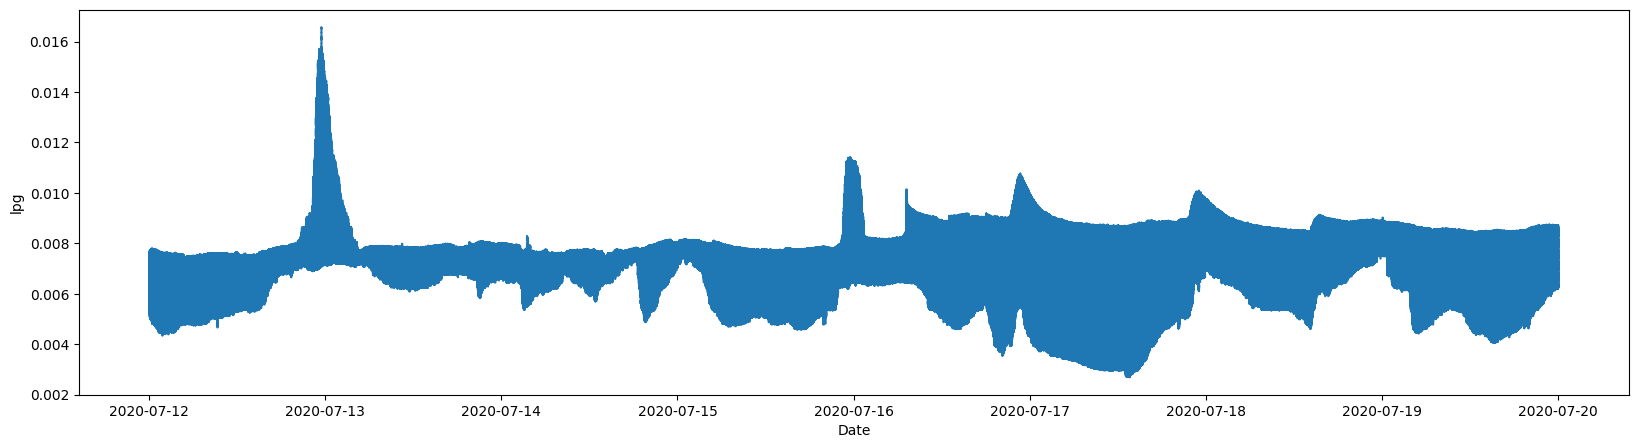

The shape of Training Data is:  (364665,)
The shape of Testing Data is:  (40519,)
0       -0.195689
1       -1.899457
2        0.936046
3       -0.197264
4       -1.899457
           ...   
40514   -0.685770
40515    0.985636
40516   -0.038692
40517   -0.685770
40518    1.009380
Name: lpg, Length: 40519, dtype: float64
X_train shape is: (364657, 8)
y_train shape is: (364657,)
X_test shape is: (40511, 8)
y_test shape is: (40511,)
Epoch 1/3
11396/11396 [==============================] - 45s 4ms/step - loss: 0.5754
Epoch 2/3
11396/11396 [==============================] - 44s 4ms/step - loss: 0.5491
Epoch 3/3
1266/1266 [==============================] - 2s 2ms/step - loss: 0.6692
RMSE on test set is 0.818
1266/1266 [==============================] - 2s 2ms/step
[-1.89945655  0.959347   -1.88119661 ... -0.03869235 -0.68576953
  1.00938047] [[-0.74482805]
 [ 0.89573365]
 [-0.5165772 ]
 ...
 [ 0.03177131]
 [ 0.33814928]
 [ 0.94394624]]


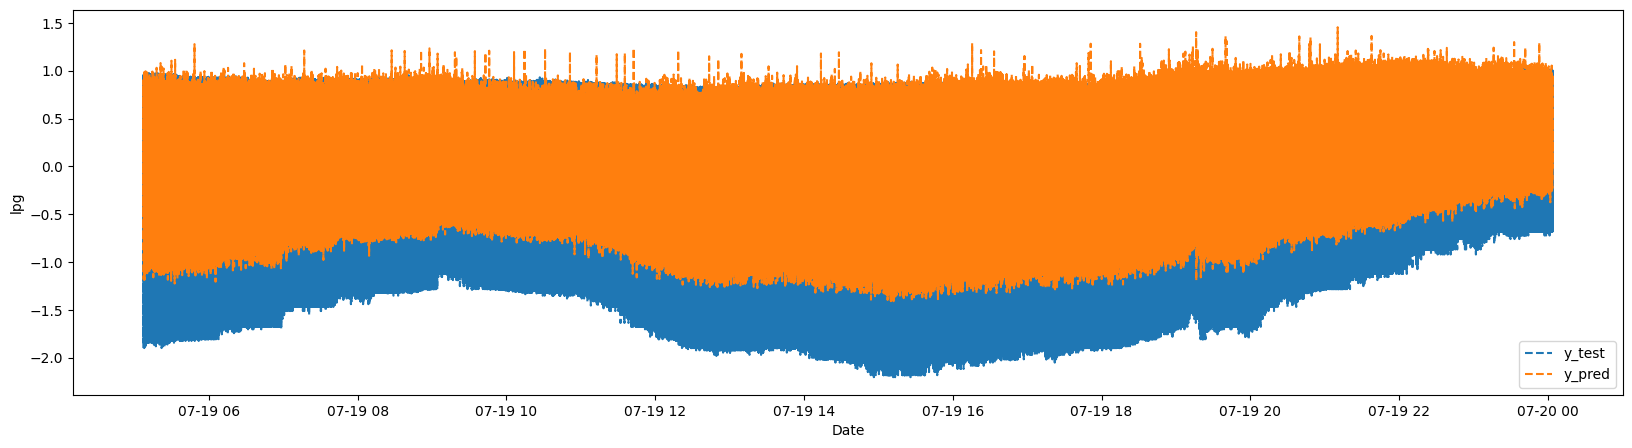

RMSE between y_pred and y is 0.818
Mean Absolute Error between y_pred and y is 0.655
R2_Score between y_pred and y is 0.394


In [12]:
#Load, Preprocess, Split, Reshape
dataset = load_clean_dataset()
dataset = timestamp_to_date(dataset)
plot(dataset)
dataset = normalise(dataset)
train, test = split_train_test(dataset)
X_train, y_train = prepare_data(train, 'train')
X_test, y_test = prepare_data(test, 'test')
X_train = reshape(X_train)
X_test = reshape(X_test)

#Design LSTM Model
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(datapoints_train, 1)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
model.fit(X_train, y_train, epochs=3, verbose=1)

#Evaluate Model
mse = model.evaluate(X_test, y_test)
rmse_test = np.sqrt(mse)
print("RMSE on test set is {}".format(round(rmse_test, 3)))

#Predict y_pred, Plot results and Evaluate Loss metrics:
y_pred = model.predict(X_test)
print(y_test, y_pred)
plot_ypred(dataset, len(train), y_test, y_pred)
loss_metrics(y_test, y_pred)